In [33]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from keras.models import load_model
import keras.backend as K
from skimage.morphology import skeletonize
from skimage.morphology import medial_axis
from skimage.morphology import remove_small_objects
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
from skan import draw
import networkx as nx
from patchify import patchify, unpatchify

# Load the trained model

In [28]:
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [29]:
# Load the saved model by providing custom metrics as custom_objects
model_root = load_model('../Task 4/model_root.h5', custom_objects={'f1_score': f1, 'intersection_over_union': iou})

# Processing the images before predicting the roots

In [35]:
def padder(image, patch_size):
 
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
 
    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding
 
    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding
 
    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
 
    return padded_image

In [34]:
def predict_mask(input_image, patch_size = 256):
    # Convert input image to grayscale
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
 
    # Adjust image dimensions
    image = padder(input_image, patch_size)
 
    # Create patches from the image
    image_patches = patchify(image, (patch_size, patch_size), step=patch_size)
    patch_rows = image_patches.shape[0]
    patch_cols = image_patches.shape[1]
    image_patches = image_patches.reshape(-1, patch_size, patch_size, 1)
 
    # Predict using the model
    patch_predictions = model_root.predict(image_patches / 255)
    patch_predictions = patch_predictions.reshape(patch_rows, patch_cols, 256, 256)
 
    # Reconstruct the image from patches
    reconstructed_image = unpatchify(patch_predictions, (image.shape[0], image.shape[1]))
 
    # Threshold the predicted mask
    mask_threshold = 0.35
    reconstructed_image = reconstructed_image > mask_threshold
    reconstructed_image = reconstructed_image.astype(np.uint8)
 
    return reconstructed_image

In [36]:
def crop_image(im):
    '''
    A function to extract region of interest from the picture. selects the biggest component which does not
    begin in (0, 0) - background, and starts before x = 4000px - side artifacts.

    Input:
        im: a multiple-channel image (cv2.threshold requires multiple channels) represented as np.array

    Output:
        im_cropped: an image cropped to contain mostly region of interest
    '''
    # finding the threshold to isolate the region of interest
    _, output = cv2.threshold(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), 50, 60, cv2.THRESH_BINARY)
    # getting rid of noise
    output = cv2.medianBlur(output, 15)
    kernel = np.ones((9, 9), dtype="uint8")
    output = cv2.erode(output, kernel, iterations=2)
    output = cv2.dilate(output, kernel, iterations=2)

    # finding components
    _, _, stats, _ = cv2.connectedComponentsWithStats(output)

    # filtering the statistics to get the right object
    # limitations on x: discard the background and other artifacts
    # limitations on width/height: make sure the object is big enough
    df = pd.DataFrame(stats, columns=['x', 'y', 'width', 'height', 'area']).sort_values('area', ascending=False)
    df = df[df['x'] > 0]
    df = df[df['x'] < 4000]
    df = df[df['height'] > 1000]
    df = df[df['width'] > 1000]

    # get the statistics for the filtered object
    x, y, width, height, _ = np.array(df.head(1))[0]

    # crop the image
    im_cropped = im[y:y + max(width, height), x:x + max(width, height)]

    dims= {"x": x, "y": y, "size": max(width, height)} 

    return im_cropped, dims

In [37]:
# Load the images
image_1 = cv2.imread('./measurement_image_1.tif')
image_2 = cv2.imread('./measurement_image_2.tif')

In [38]:
# Crop the images
cropped_image_1, dims_1 = crop_image(image_1)
cropped_image_2, dims_2 = crop_image(image_2)

In [39]:
# Predict the masks
predicted_mask_1 = predict_mask(cropped_image_1, patch_size=256)
predicted_mask_2 = predict_mask(cropped_image_2, patch_size=256)

4/4 [==============================] - 2s 426ms/step


In [40]:
def segment_instances(mask):
    # Detect connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # Initialize an output image to hold the segmented instances (with 3 color channels)
    output_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    # Generate unique colors for each component
    unique_colors = np.random.randint(0, 256, (num_labels, 3))

    # Calculate the dynamic threshold for each connected component
    thresholds = [int(0.75 * area) for area in stats[1:, -1]]

    # Define minimum area threshold for filtering components
    min_area_threshold = 500  # Adjust this value as needed

    for i in range(1, num_labels):  # Include the background label (0)
        # Extract bounding box dimensions
        x, y, width, height, area = stats[i]

        # Filter components based on minimum area and dynamic threshold
        if area > min_area_threshold and area > thresholds[i - 1]:
            output_image[labels == i] = unique_colors[i]

    return output_image

In [41]:
segment_1 = segment_instances(predicted_mask_1)
segment_2 = segment_instances(predicted_mask_2)

# Get the lenghts of the root

In [43]:
def generate_skeleton_summary(segmented_binary_image):
    # Convert the first channel of the segmented_binary_image to a binary image
    binary_image = np.where(segmented_binary_image[:, :, 0] != 0, 1, 0)

    # Skeletonize the binary image
    skeletonized_image = skeletonize(binary_image)

    # Generate and reset the index of the skeleton summary data
    skeleton_summary = summarize(Skeleton(skeletonized_image)).reset_index()

    return skeleton_summary

In [48]:
def analyze_skeleton(skeleton_summary, skeleton_id):
    # Create a graph from the skeleton data
    G = nx.from_pandas_edgelist(
        skeleton_summary,
        source="node-id-src",
        target="node-id-dst",
        edge_attr="branch-distance"
    )

    # Create a graph to store root data
    root_graph = nx.Graph()

    # Add edges with attributes
    for idx, row in skeleton_summary.iterrows():
        root_graph.add_edge(row['node-id-src'], row['node-id-dst'], length=row['branch-distance'])

    # Extract skeleton information for the given skeleton ID
    skeleton = skeleton_summary[skeleton_summary['skeleton-id'] == skeleton_id]

    # Identify primary root start and end nodes
    primary_start_node = skeleton.loc[skeleton['coord-src-0'].idxmin(), 'node-id-src']
    primary_end_node = skeleton.loc[skeleton['coord-dst-0'].idxmax(), 'node-id-dst']

    # Calculate primary root length
    primary_length = nx.shortest_path_length(root_graph, primary_start_node, primary_end_node, weight='length')

    # Find lateral roots
    lateral_roots = skeleton[skeleton['branch-type'] == 1]
    lateral_lengths = []
    for index, lateral_root in lateral_roots.iterrows():
        # Calculate lateral root length
        lateral_length = nx.shortest_path_length(root_graph, lateral_root['node-id-src'], lateral_root['node-id-dst'], weight='length')
        lateral_lengths.append(lateral_length)

    return {
        'skeleton_id': skeleton_id,
        'primary_root_length': primary_length,
        'lateral_root_lengths': lateral_lengths
    }

In [69]:
import numpy as np

def sMAPE(preds, labels):
    return 100 * np.mean(np.abs(preds - labels) / ((np.abs(preds) + np.abs(labels)) / 2))

# Plant 1

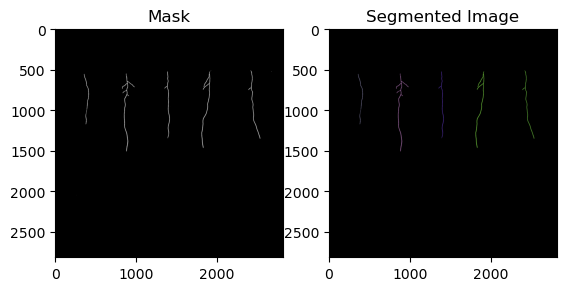

In [54]:
plt.figure(figsize=(10, 8))

# Plot image
plt.subplot(231)
plt.title('Mask')
plt.imshow(predicted_mask_1, cmap='gray')

# Plot image
plt.subplot(232)
plt.title('Segmented Image')
plt.imshow(segment_1, cmap='gray')

plt.show()

In [44]:
summary_data_1 = generate_skeleton_summary(segment_1)
summary_data_1

,index,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,0,1376,227.083261,1,1.0,0.0,513,2416,725,2423,513,2416,725,2423,212.115535
1,1,1,13,145,42.899495,1,1.0,0.0,523,1914,561,1905,523,1914,561,1905,39.051248
2,2,2,21,1220,193.597980,1,1.0,0.0,527,1389,709,1385,527,1389,709,1385,182.043951
3,3,3,81,665,106.798990,1,1.0,0.0,547,880,648,890,547,880,648,890,101.493842
4,4,4,117,3774,662.078210,0,1.0,0.0,556,361,1175,379,556,361,1175,379,619.261657
5,5,1,145,885,121.213203,2,1.0,0.0,561,1905,675,1905,561,1905,675,1905,114.000000
6,6,1,145,1248,178.580736,1,1.0,0.0,561,1905,711,1838,561,1905,711,1838,164.283292
7,7,3,665,1297,121.923882,1,1.0,0.0,648,890,716,982,648,890,716,982,114.402797
8,8,3,665,848,24.828427,2,1.0,0.0,648,890,672,892,648,890,672,892,24.083189
9,9,3,848,1468,98.225397,1,1.0,0.0,672,892,735,831,672,892,735,831,87.692645


In [58]:
selected_skeleton_id = 0  # Skeleton ID
result_1_0 = analyze_skeleton(summary_data_1, selected_skeleton_id)
print(f"Plant Skeleton ID: {result_1_0['skeleton_id']}")
print(f"Primary Root Length: {result_1_0['primary_root_length']}")
for i, l_length in enumerate(result_1_0['lateral_root_lengths']):
    print(f"Lateral Root {i+1} Length: {l_length}")

Plant Skeleton ID: 0
Primary Root Length: 910.8305191658006
Lateral Root 1 Length: 227.08326112068536
Lateral Root 2 Length: 44.11269837220807
Lateral Root 3 Length: 683.7472580451152


In [59]:
selected_skeleton_id = 1  # Skeleton ID
result_1_1 = analyze_skeleton(summary_data_1, selected_skeleton_id)
print(f"Plant Skeleton ID: {result_1_1['skeleton_id']}")
print(f"Primary Root Length: {result_1_1['primary_root_length']}")
for i, l_length in enumerate(result_1_1['lateral_root_lengths']):
    print(f"Lateral Root {i+1} Length: {l_length}")

Plant Skeleton ID: 1
Primary Root Length: 1011.203102167831
Lateral Root 1 Length: 42.89949493661167
Lateral Root 2 Length: 178.58073580374364
Lateral Root 3 Length: 112.68124086713178
Lateral Root 4 Length: 847.0904037956229


In [55]:
selected_skeleton_id = 2  # Skeleton ID
result_1_2 = analyze_skeleton(summary_data_1, selected_skeleton_id)
print(f"Plant Skeleton ID: {result_1_2['skeleton_id']}")
print(f"Primary Root Length: {result_1_2['primary_root_length']}")
for i, l_length in enumerate(result_1_2['lateral_root_lengths']):
    print(f"Lateral Root {i+1} Length: {l_length}")

Plant Skeleton ID: 2
Primary Root Length: 864.9777054234144
Lateral Root 1 Length: 193.59797974644675
Lateral Root 2 Length: 44.28427124746189
Lateral Root 3 Length: 671.3797256769676


In [56]:
selected_skeleton_id = 3  # Skeleton ID
result_1_3 = analyze_skeleton(summary_data_1, selected_skeleton_id)
print(f"Plant Skeleton ID: {result_1_3['skeleton_id']}")
print(f"Primary Root Length: {result_1_3['primary_root_length']}")
for i, l_length in enumerate(result_1_3['lateral_root_lengths']):
    print(f"Lateral Root {i+1} Length: {l_length}")

Plant Skeleton ID: 3
Primary Root Length: 1028.3746750430842
Lateral Root 1 Length: 106.7989898732233
Lateral Root 2 Length: 121.92388155425104
Lateral Root 3 Length: 98.22539674441612
Lateral Root 4 Length: 63.01219330881971
Lateral Root 5 Length: 745.9777054234144
Lateral Root 6 Length: 31.213203435596434


In [57]:
selected_skeleton_id = 4  # Skeleton ID
result_1_4 = analyze_skeleton(summary_data_1, selected_skeleton_id)
print(f"Plant Skeleton ID: {result_1_4['skeleton_id']}")
print(f"Primary Root Length: {result_1_4['primary_root_length']}")
for i, l_length in enumerate(result_1_4['lateral_root_lengths']):
    print(f"Lateral Root {i+1} Length: {l_length}")

Plant Skeleton ID: 4
Primary Root Length: 662.0782104868026


# Chacking sMAPE of Plant 1

In [99]:
root_pred_1 = [
    {'Plant_1': 1, 'primary_root_length': 662.0782104868026, 'lateral_root_lengths': []},
    {'Plant_2': 2, 'primary_root_length': 1028.3746750430842, 'lateral_root_lengths': [106.7989898732233, 121.92388155425104, 98.22539674441612, 63.01219330881971, 745.9777054234144, 31.213203435596434]},
    {'Plant_3': 3, 'primary_root_length': 864.9777054234144, 'lateral_root_lengths': [193.59797974644675, 44.28427124746189, 671.3797256769676]},
    {'Plant_4': 4, 'primary_root_length': 1011.203102167831, 'lateral_root_lengths': [42.89949493661167, 178.58073580374364, 112.68124086713178, 847.0904037956229]},
    {'Plant_5': 5, 'primary_root_length': 910.8305191658006, 'lateral_root_lengths': [227.08326112068536, 44.11269837220807, 683.7472580451152]}
]

root_act_1 = [
    {'Plant_1': 1, 'primary_root_length': 675.321 , 'lateral_root_lengths': []},
    {'Plant_2': 2, 'primary_root_length': 1036.375 , 'lateral_root_lengths': [ 103.397, 60.012, 197.179, 26.799]},
    {'Plant_3': 3, 'primary_root_length': 875.321 , 'lateral_root_lengths': [39.284]},
    {'Plant_4': 4, 'primary_root_length': 973.233 , 'lateral_root_lengths': [111.267, 185.581, 26.556]},
    {'Plant_5': 5, 'primary_root_length': 874.931 , 'lateral_root_lengths': [43.527]}
]

# Convert the list of dictionaries to a DataFrame
root_1_pred_df = pd.DataFrame(root_pred_1)
root_1_act_df = pd.DataFrame(root_act_1)

# Extract primary root lengths as a NumPy array
pred_lenghts_prim_1 = np.array(root_1_pred_df['primary_root_length'])
actual_lenghts_prim_1 = np.array(root_1_act_df['primary_root_length'])

# Extract lateral root lengths as a NumPy array (handling the fact that it contains lists)
pred_lengths_lat_1 = root_1_pred_df['lateral_root_lengths'].apply(np.sum).to_numpy()
actual_lengths_lat_1 = root_1_act_df['lateral_root_lengths'].apply(np.sum).to_numpy()


In [100]:
import numpy as np

def sMAPE(preds, labels):
    return 100 * np.mean(np.abs(preds - labels) / ((np.abs(preds) + np.abs(labels)) / 2))

# Calculate sMAPE
smape_value_prim_1 = sMAPE(pred_lenghts_prim_1, actual_lenghts_prim_1)
print(f'sMAPE Primary_roots: {smape_value_prim_1}')

sMAPE Primary_roots: 2.3582867062126183


In [101]:
def sMAPE(preds, labels):
    denominator = np.abs(preds) + np.abs(labels)
    mask = denominator != 0  # Avoid division by zero
    return 100 * np.mean(np.abs(preds - labels)[mask] / (denominator[mask] / 2))


smape_value_lat_1 = sMAPE(pred_lengths_lat_1, actual_lengths_lat_1)
print(f'sMAPE Lateral_roots: {smape_value_lat_1}')

sMAPE Lateral_roots: 145.0858368421873


# Plant 2

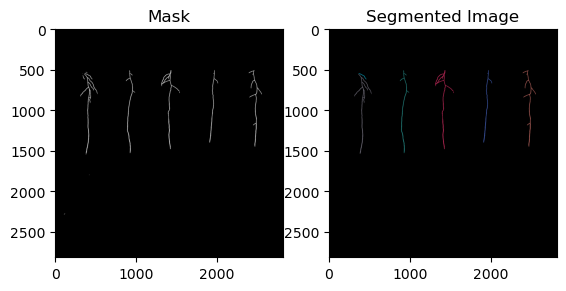

In [60]:
plt.figure(figsize=(10, 8))

# Plot image
plt.subplot(231)
plt.title('Mask')
plt.imshow(predicted_mask_2, cmap='gray')

# Plot image
plt.subplot(232)
plt.title('Segmented Image')
plt.imshow(segment_2, cmap='gray')

plt.show()

In [61]:
summary_data_2 = generate_skeleton_summary(segment_2)
summary_data_2

,index,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,0,224,40.242641,1,1.0,0.0,507,1970,546,1967,507,1970,546,1967,39.115214
1,1,1,3,54,12.071068,1,1.0,0.0,509,2460,518,2454,509,2460,518,2454,10.816654
2,2,2,8,65,12.485281,1,1.0,0.0,512,1423,520,1431,512,1423,520,1431,11.313708
3,3,2,9,65,11.071068,1,1.0,0.0,512,1437,520,1431,512,1437,520,1431,10.000000
4,4,3,12,236,37.071068,1,1.0,0.0,513,920,548,923,513,920,548,923,35.128336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,56,5,3383,6701,728.994949,1,1.0,0.0,843,417,1542,384,843,417,1542,384,699.778536
57,57,5,3383,3439,20.485281,2,1.0,0.0,843,417,849,435,843,417,849,435,18.973666
58,58,5,3439,3823,69.798990,1,1.0,0.0,849,435,913,433,849,435,913,433,64.031242
59,59,1,5079,5221,43.698485,1,1.0,0.0,1163,2484,1185,2450,1163,2484,1185,2450,40.496913


In [62]:
selected_skeleton_id = 0  # Skeleton ID
result_2_0 = analyze_skeleton(summary_data_2, selected_skeleton_id)
print(f"Plant Skeleton ID: {result_2_0['skeleton_id']}")
print(f"Primary Root Length: {result_2_0['primary_root_length']}")
for i, l_length in enumerate(result_2_0['lateral_root_lengths']):
    print(f"Lateral Root {i+1} Length: {l_length}")

Plant Skeleton ID: 0
Primary Root Length: 934.4213562373103
Lateral Root 1 Length: 40.242640687119284
Lateral Root 2 Length: 11.828427124746192
Lateral Root 3 Length: 82.0832611206852
Lateral Root 4 Length: 823.5218613006987


In [63]:
selected_skeleton_id = 1  # Skeleton ID
result_2_1 = analyze_skeleton(summary_data_2, selected_skeleton_id)
print(f"Plant Skeleton ID: {result_2_1['skeleton_id']}")
print(f"Primary Root Length: {result_2_1['primary_root_length']}")
for i, l_length in enumerate(result_2_1['lateral_root_lengths']):
    print(f"Lateral Root {i+1} Length: {l_length}")

Plant Skeleton ID: 1
Primary Root Length: 998.3330444827412
Lateral Root 1 Length: 12.071067811865476
Lateral Root 2 Length: 70.76955262170043
Lateral Root 3 Length: 11.485281374238571
Lateral Root 4 Length: 121.49747468305827
Lateral Root 5 Length: 105.53910524340085
Lateral Root 6 Length: 93.32590180780444
Lateral Root 7 Length: 43.69848480983499
Lateral Root 8 Length: 297.35533905932755


In [64]:
selected_skeleton_id = 2  # Skeleton ID
result_2_2 = analyze_skeleton(summary_data_2, selected_skeleton_id)
print(f"Plant Skeleton ID: {result_2_2['skeleton_id']}")
print(f"Primary Root Length: {result_2_2['primary_root_length']}")
for i, l_length in enumerate(result_2_2['lateral_root_lengths']):
    print(f"Lateral Root {i+1} Length: {l_length}")

Plant Skeleton ID: 2
Primary Root Length: 1030.5756851698611
Lateral Root 1 Length: 12.485281374238571
Lateral Root 2 Length: 11.071067811865476
Lateral Root 3 Length: 27.82842712474619
Lateral Root 4 Length: 2.0
Lateral Root 5 Length: 27.485281374238575
Lateral Root 6 Length: 151.40916292848965
Lateral Root 7 Length: 823.3502884254449


In [65]:
selected_skeleton_id = 3  # Skeleton ID
result_2_3 = analyze_skeleton(summary_data_2, selected_skeleton_id)
print(f"Plant Skeleton ID: {result_2_3['skeleton_id']}")
print(f"Primary Root Length: {result_2_3['primary_root_length']}")
for i, l_length in enumerate(result_2_3['lateral_root_lengths']):
    print(f"Lateral Root {i+1} Length: {l_length}")

Plant Skeleton ID: 3
Primary Root Length: 1077.4751801064726
Lateral Root 1 Length: 37.07106781186547
Lateral Root 2 Length: 43.284271247461895
Lateral Root 3 Length: 66.08326112068518
Lateral Root 4 Length: 41.69848480983499
Lateral Root 5 Length: 811.9066376115488


In [67]:
selected_skeleton_id = 5  # Skeleton ID
result_2_4 = analyze_skeleton(summary_data_2, selected_skeleton_id)
print(f"Plant Skeleton ID: {result_2_4['skeleton_id']}")
print(f"Primary Root Length: {result_2_4['primary_root_length']}")
for i, l_length in enumerate(result_2_4['lateral_root_lengths']):
    print(f"Lateral Root {i+1} Length: {l_length}")

Plant Skeleton ID: 5
Primary Root Length: 1051.0609665440993
Lateral Root 1 Length: 62.49747468305829
Lateral Root 2 Length: 260.4629867976526
Lateral Root 3 Length: 132.19595949289322
Lateral Root 4 Length: 157.27922061357856
Lateral Root 5 Length: 728.9949493661172
Lateral Root 6 Length: 69.79898987322332


In [104]:
root_pred_2 = [
    {'Plant_1': 1, 'primary_root_length': 1051.0609665440993, 'lateral_root_lengths': [62.49747468305829, 260.4629867976526, 132.19595949289322, 157.27922061357856, 728.9949493661172, 69.79898987322332]},
    {'Plant_2': 2, 'primary_root_length': 1077.4751801064726, 'lateral_root_lengths': [37.07106781186547, 43.284271247461895, 66.08326112068518, 41.69848480983499, 811.9066376115488]},
    {'Plant_3': 3, 'primary_root_length': 1030.5756851698611, 'lateral_root_lengths': [12.485281374238571, 11.071067811865476, 27.82842712474619, 2.0, 27.485281374238575, 151.40916292848965, 823.3502884254449]},
    {'Plant_4': 4, 'primary_root_length': 998.3330444827412, 'lateral_root_lengths': [12.071067811865476, 70.76955262170043, 11.485281374238571, 121.49747468305827, 105.53910524340085, 93.32590180780444, 43.69848480983499, 297.35533905932755]},
    {'Plant_0': 0, 'primary_root_length': 934.4213562373103, 'lateral_root_lengths': [40.242640687119284, 11.828427124746192, 82.0832611206852, 823.5218613006987]}
]

root_act_2 = [
    {'Plant_1': 1, 'primary_root_length': 988.676, 'lateral_root_lengths': [155.279, 84.598, 6.828, 132.024, 19.485, 19.265, 259.291, 131.267, 103.698, 76.627, 3.000, 12.485, 4.243]},
    {'Plant_2': 2, 'primary_root_length': 1103.688, 'lateral_root_lengths': [60.012, 39.941, 37.527]},
    {'Plant_3': 3, 'primary_root_length': 969.534, 'lateral_root_lengths': [191.238, 116.924, 97.326, 63.184, 35.071, 25.485, 20.556, 14.314, 14.071, 8.657, 5.828, 15.243, 37.87, 147.238]},
    {'Plant_4': 4, 'primary_root_length': 946.25, 'lateral_root_lengths': [8.657, 77.912]},
    {'Plant_5': 5, 'primary_root_length': 1004.09, 'lateral_root_lengths': [65.113, 89.326, 121.74, 14.314, 42.527, 98.125]}
]

# Convert the list of dictionaries to a DataFrame
root_2_pred_df = pd.DataFrame(root_pred_2)
root_2_act_df = pd.DataFrame(root_act_2)

# Extract primary root lengths and secondary root lengths as NumPy arrays
pred_lengths_prim_2 = np.array([entry['primary_root_length'] for entry in root_pred_2])
act_lengths_prim_2 = np.array([entry['primary_root_length'] for entry in root_act_2])

# Extract lateral root lengths as a NumPy array (handling the fact that it contains lists)
pred_lengths_lat_2 = root_2_pred_df['lateral_root_lengths'].apply(np.sum).to_numpy()
actual_lengths_lat_2 = root_2_act_df['lateral_root_lengths'].apply(np.sum).to_numpy()

In [106]:
import numpy as np

def sMAPE(preds, labels):
    return 100 * np.mean(np.abs(preds - labels) / ((np.abs(preds) + np.abs(labels)) / 2))

# Calculate sMAPE
smape_value_prim_2 = sMAPE(pred_lengths_prim_2, act_lengths_prim_2)
print(f'sMAPE Primary_roots: {smape_value_prim_2}')

sMAPE Primary_roots: 5.433788065806645


In [107]:
def sMAPE(preds, labels):
    denominator = np.abs(preds) + np.abs(labels)
    mask = denominator != 0  # Avoid division by zero
    return 100 * np.mean(np.abs(preds - labels)[mask] / (denominator[mask] / 2))


smape_value_lat_2 = sMAPE(pred_lengths_lat_2, actual_lengths_lat_2)
print(f'sMAPE Lateral_roots: {smape_value_lat_2}')

sMAPE Lateral_roots: 89.62197208249411
